In [21]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
import time
import warnings
warnings.filterwarnings('ignore')

In [22]:
cols = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Deck_Cabin", "Side_Cabin"]
labelCols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck_Cabin", "Side_Cabin"]
numericalCols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
def preprocessingData(data):
    """
    The PassengerId and Name features don't provide any useful information that can help us predict the 
    Transported feature. The Cabin feature takes the form Deck/Num/Side. The Num part isn't too relevant 
    but the Deck and Side parts might be useful in predicting the Transported feature.
    """
    cabinSplit = data['Cabin'].str.split("/", expand=True)
    data['Deck_Cabin'] = cabinSplit[0]
    data['Side_Cabin'] = cabinSplit[2]
    data = data.drop(columns=["PassengerId", "Name", "Cabin"])
    
    #Filling the nan values in every numerical feature except Age with the mode value
    #Filling the nan values in the Age feature with the mean value
    #Standardizing the numerical columns so that all the values in these columns are on the same numerical scale
    #Filling the nan values in these categorical features with the mode value
    #Transforming the categorical features to store int labels
    label_encoder = preprocessing.LabelEncoder()
    for col in cols:
        if col in numericalCols:
            if col == "Age":
                data[col] = data[col].fillna(data[col].mean())
            else:
                data[col] = data[col].fillna(data[col].mode()[0])
            data[col] = (data[col] - data[col].mean())/(data[col].std())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            data[col] = label_encoder.fit_transform(data[col])
            data[col] = data[col].astype(int)
        
    return data


In [23]:
data = pd.read_csv("train.csv")
data = preprocessingData(data)
X = data.drop(columns=["Transported"])
y = data["Transported"]

#Using Bayesian Optimization to tune the hyperparameters
max_score = (0, {})
def generateRandomForest(max_samples, max_features, estimator, depth):
    return RandomForestClassifier(max_samples=max_samples, max_features=max_features, n_estimators=estimator, max_depth=depth)

def score(max_samples, max_features, estimator, depth):
    max_features = round(max_features)
    estimator = round(estimator)
    depth = round(depth)
    
    def generateModel():
        return generateRandomForest(max_samples, max_features, estimator, depth)
        
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    model = generateModel()
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=kfold)
    mean_acc = scores.mean()
    global max_score
    if mean_acc > max_score[0]:
        max_score = (mean_acc, {
            'max_samples': max_samples,
            'max_features': max_features,
            'estimator': estimator,
            'depth': depth
        })
    return mean_acc

hyperparams = {
    'max_samples': (0.1, 1),
    'max_features': (4, 12),
    'estimator': (10, 100),
    'depth': (1, 7)
}
start = time.time()
bo = BayesianOptimization(score, hyperparams, random_state=1)
bo.maximize(init_points=200, n_iter=10)
print("Best Accuracy: %f using %s" % (max_score[0], str(max_score[1])))
end = time.time()
elapsedTime = end - start
print("Elapsed Time: " + str(elapsedTime) + " seconds")

|   iter    |  target   |   depth   | estimator | max_fe... | max_sa... |
-------------------------------------------------------------------------
| 1         | 0.7737    | 3.502     | 74.83     | 4.001     | 0.3721    |
| 2         | 0.7314    | 1.881     | 18.31     | 5.49      | 0.411     |
| 3         | 0.7537    | 3.381     | 58.49     | 7.354     | 0.7167    |
| 4         | 0.7389    | 2.227     | 89.03     | 4.219     | 0.7034    |
| 5         | 0.7776    | 3.504     | 60.28     | 5.123     | 0.2783    |
| 6         | 0.7939    | 5.804     | 97.14     | 6.507     | 0.7231    |
| 7         | 0.7957    | 6.258     | 90.51     | 4.68      | 0.1351    |
| 8         | 0.7381    | 2.019     | 89.03     | 4.787     | 0.479     |
| 9         | 0.7986    | 6.747     | 57.98     | 9.535     | 0.384     |
| 10        | 0.784     | 5.119     | 85.12     | 4.146     | 0.7751    |
| 11        | 0.7997    | 6.933     | 77.33     | 6.244     | 0.8104    |
| 12        | 0.7183    | 1.619     | 

| 67        | 0.7945    | 6.187     | 39.04     | 9.366     | 0.5058    |
| 68        | 0.7584    | 3.293     | 46.97     | 7.212     | 0.3856    |
| 69        | 0.7894    | 4.732     | 48.72     | 11.79     | 0.71      |
| 70        | 0.724     | 2.191     | 48.4      | 6.747     | 0.8179    |
| 71        | 0.7972    | 6.28      | 91.35     | 9.302     | 0.3432    |
| 72        | 0.7551    | 2.514     | 86.94     | 8.222     | 0.8219    |
| 73        | 0.7813    | 4.435     | 75.98     | 8.152     | 0.7938    |
| 74        | 0.7872    | 4.413     | 51.91     | 6.742     | 0.1614    |
| 75        | 0.7574    | 3.268     | 17.17     | 11.86     | 0.2635    |
| 76        | 0.7959    | 5.871     | 88.75     | 9.507     | 0.6125    |
| 77        | 0.7233    | 1.966     | 52.02     | 6.761     | 0.3025    |
| 78        | 0.789     | 4.555     | 38.1      | 11.33     | 0.9187    |
| 79        | 0.7604    | 2.543     | 19.98     | 5.544     | 0.5496    |
| 80        | 0.7891    | 5.372     | 

| 135       | 0.7849    | 5.012     | 52.92     | 4.105     | 0.4177    |
| 136       | 0.7813    | 3.952     | 75.71     | 7.749     | 0.5117    |
| 137       | 0.7238    | 1.826     | 10.98     | 10.07     | 0.388     |
| 138       | 0.794     | 6.906     | 29.82     | 6.71      | 0.5715    |
| 139       | 0.7932    | 5.529     | 51.75     | 4.999     | 0.3813    |
| 140       | 0.7872    | 4.027     | 70.65     | 10.16     | 0.2173    |
| 141       | 0.7183    | 1.137     | 56.72     | 10.48     | 0.1113    |
| 142       | 0.7898    | 5.035     | 71.81     | 7.594     | 0.9233    |
| 143       | 0.7893    | 4.866     | 10.47     | 7.875     | 0.8734    |
| 144       | 0.7937    | 5.982     | 68.42     | 9.39      | 0.6206    |
| 145       | 0.7567    | 2.645     | 60.45     | 9.374     | 0.4172    |
| 146       | 0.7934    | 6.135     | 27.55     | 9.979     | 0.3606    |
| 147       | 0.7956    | 5.643     | 48.5      | 10.46     | 0.4182    |
| 148       | 0.7294    | 2.282     | 

| 203       | 0.7935    | 7.0       | 75.77     | 4.0       | 0.1       |
| 204       | 0.7949    | 6.954     | 13.18     | 7.2       | 0.9163    |
| 205       | 0.7922    | 7.0       | 96.34     | 4.0       | 0.1       |
| 206       | 0.7979    | 6.99      | 87.1      | 7.462     | 0.7516    |
| 207       | 0.7965    | 7.0       | 62.35     | 7.447     | 0.1       |
| 208       | 0.7865    | 7.0       | 15.23     | 4.0       | 0.1       |
| 209       | 0.7963    | 7.0       | 33.69     | 6.935     | 1.0       |
| 210       | 0.7952    | 7.0       | 82.44     | 12.0      | 1.0       |
Best Accuracy: 0.799723 using {'max_samples': 0.8103513956063396, 'max_features': 6, 'estimator': 77, 'depth': 7}
Elapsed Time: 1230.0305399894714 seconds


In [25]:
"""
According to the output above, the hyperparameter values that displayed the best performance are
{'max_samples': 0.8103513956063396, 'max_features': 6, 'estimator': 77, 'depth': 7}
"""

hyperparams = max_score[1]

"""
Precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
Recall is intuitively the ability of the classifier to find all the positive samples.
F1-score score can be interpreted as a weighted harmonic mean of the precision and recall, where an F1-score 
reaches its best value at 1 and its worst score at 0.
"""
model = generateRandomForest(hyperparams['max_samples'], hyperparams['max_features'], hyperparams['estimator'], hyperparams['depth'])
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.77      0.80      4315
        True       0.79      0.86      0.82      4378

    accuracy                           0.81      8693
   macro avg       0.82      0.81      0.81      8693
weighted avg       0.82      0.81      0.81      8693



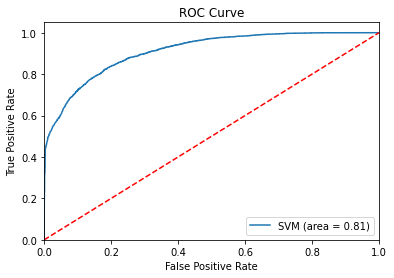

In [26]:
"""
The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away 
from that line as possible
"""
logit_roc_auc = roc_auc_score(y, y_pred)
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
#Final predictions on the test set to provide for submission
test_data = pd.read_csv("test.csv")
passenger_ids = test_data["PassengerId"]
test_data = preprocessingData(test_data)

model = generateRandomForest(hyperparams['max_samples'], hyperparams['max_features'], hyperparams['estimator'], hyperparams['depth'])
model.fit(X, y)
y_pred = model.predict(test_data)

final_submission = pd.DataFrame()
final_submission["PassengerId"] = passenger_ids
final_submission["Transported"] = y_pred
final_submission.to_csv('RandomForestSubmission.csv', index=False)
#Final Submission Produced an accuracy of 0.77203 on the test set